# Demo 1: Killing Pythia - Metabolic Attack Demonstration

This notebook demonstrates how to induce spectral collapse in Pythia models using metabolic attacks via our experimental infrastructure.

**The Hook**: We prove mathematically and empirically that larger models are structurally more fragile to metabolic attacks.

## Two Ways to Run Experiments

1. **Quick Demo** (this notebook): Use `run_experiment.py` for a single experimental run
2. **Full Experiments**: Use `experiment_orchestrator.py` for complete Priority experiments (see README)

## What You'll See

1. **Running an Attack**: Execute a metabolic attack using the infrastructure script
2. **Results Analysis**: Load and visualize the attack results
3. **Spectral Collapse**: Effective rank reduction visualized from saved metrics

In [1]:
import subprocess
import sys
import json
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# Setup paths
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
experiment_dir = project_root / "experiments" / "01_pythia_160m"

print("📦 Setting up experiment infrastructure...")
print(f"Project root: {project_root}")
print(f"Experiment directory: {experiment_dir}")

# Check if infrastructure exists
run_experiment_script = experiment_dir / "run_experiment.py"
if not run_experiment_script.exists():
    raise FileNotFoundError(f"Infrastructure script not found: {run_experiment_script}")

print("✅ Infrastructure ready!")

📦 Setting up experiment infrastructure...
Project root: /backup/d.yin/NeuroEntropy
Experiment directory: /backup/d.yin/NeuroEntropy/experiments/01_pythia_160m
✅ Infrastructure ready!


In [ ]:
# Run a single attack experiment using run_experiment.py
# This demonstrates the metabolic attack on Pythia-160M

model = "160m"
output_dir = project_root / "experiments" / "results" / "demo"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n🚀 Running metabolic attack on Pythia-{model}...")
print(f"Output directory: {output_dir}")

# Build command
cmd = [
    sys.executable,
    str(run_experiment_script),
    "--model", model,
    "--quantization", "fp16",
    "--force-fft",
    "--control-type", "eigen_prion",  # Treatment group
    "--num-runs", "1",  # Single run for demo
    "--seed", "42",
    "--output-dir", str(output_dir),
    "--verbosity", "normal"
]

print(f"\nCommand: {' '.join(cmd)}\n")
print("="*70)

# Run experiment
result = subprocess.run(cmd, cwd=str(project_root))

if result.returncode == 0:
    print("\n✅ Experiment completed successfully!")
else:
    print(f"\n❌ Experiment failed with return code {result.returncode}")
    sys.exit(1)


🚀 Running metabolic attack on Pythia-160m...
Output directory: /backup/d.yin/NeuroEntropy/experiments/results/demo

Command: /backup/conda/venvs/neuroentropy/bin/python /backup/d.yin/NeuroEntropy/experiments/01_pythia_160m/run_experiment.py --model 160m --quantization fp16 --force-fft --control-type eigen_prion --num-runs 1 --seed 42 --output-dir /backup/d.yin/NeuroEntropy/experiments/results/demo --verbosity normal


EXPERIMENT CONFIGURATION
Model: 160m
Quantization: fp16
Number of runs: 1
Seed: 42
Save checkpoints: False

##################################################
RUN 1/1
Using seed: 43 (base_seed=42 + run_number=1)
##################################################
Loading model: EleutherAI/pythia-160m


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 3871.05it/s, Materializing param=gpt_neox.layers.11.post_attention_layernorm.weight] 


Gradient checkpointing enabled
Full Fine-Tuning mode: All parameters trainable

PHASE 1: Baseline Measurement
Measuring baseline metrics...


Computing perplexity: 100%|██████████| 10/10 [00:00<00:00, 20.21it/s]


Baseline - Perplexity: 2539.74, Effective Rank: 2.86
Model reset to baseline state before eigen_prion (from memory)

PHASE 2: Treatment Group (Eigen-Prion)
Running treatment group: 100 steps of Eigen-Prion (optimizer: adamw)...


/backup/conda/venvs/neuroentropy/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Using Adafactor optimizer (zero optimizer state overhead) for 148 trainable parameters


Attack cycle:   0%|          | 0/100 [00:00<?, ?it/s]


Plot saved to /backup/d.yin/NeuroEntropy/experiments/results/demo/pythia_160m_pythia-160m_fp16_eigen_prion/treatment_rank_collapse.png
Plot saved to /backup/d.yin/NeuroEntropy/experiments/results/demo/pythia_160m_pythia-160m_fp16_eigen_prion/treatment_rank_reduction.png

PHASE 4: Post-Attack Measurement
Measuring baseline metrics...


Computing perplexity: 100%|██████████| 10/10 [00:00<00:00, 64.55it/s]


Post-Attack - Perplexity: 4050.87, Effective Rank: 2.86

PHASE 5: Generating Spectral Decay Plot
Spectral decay plot saved to /backup/d.yin/NeuroEntropy/experiments/results/demo/pythia_160m_pythia-160m_fp16_eigen_prion/spectral_decay.png
Spectral decay plot generated successfully!

EXPERIMENT SUMMARY
Initial Effective Rank: 2.86
Final Effective Rank: 2.86
Rank Reduction: -0.11%

Results saved to: /backup/d.yin/NeuroEntropy/experiments/results/demo/pythia_160m_pythia-160m_fp16_eigen_prion

Run 1 Summary:
  Rank Reduction: -0.11%
  Results saved to: /backup/d.yin/NeuroEntropy/experiments/results/demo/pythia_160m_pythia-160m_fp16_eigen_prion

✅ Experiment completed successfully!


In [6]:
# Load and analyze results from the experiment
# Find the most recent run directory (try multiple patterns)
print(f"🔍 Searching for results in: {output_dir}")

# Try different directory patterns (order matters - try most specific first)
patterns = [
    f"pythia_{model}_pythia-{model}_run*_fp16_eigen_prion",  # With run number (multiple runs)
    f"pythia_{model}_pythia-{model}_fp16_eigen_prion",      # Without run number (single run)
    f"pythia_{model}_pythia-{model}_run*_fp16",             # With run, no treatment suffix
    f"pythia_{model}_pythia-{model}_fp16",                  # Without run, no treatment suffix
    f"*{model}*eigen_prion*",                               # Any with model and treatment
    f"*{model}*fp16*",                                      # Any with model and precision
]

run_dirs = []
for pattern in patterns:
    found_dirs = sorted(output_dir.glob(pattern))
    if found_dirs:
        run_dirs = found_dirs
        print(f"✅ Found {len(found_dirs)} directories matching pattern: {pattern}")
        break

if not run_dirs:
    # List all directories to help debug
    all_dirs = [d for d in output_dir.iterdir() if d.is_dir()]
    print(f"⚠️ No run directories found. Available directories:")
    for d in all_dirs:
        print(f"   - {d.name}")
    raise FileNotFoundError(f"No run directories found in {output_dir}. Make sure Cell 2 completed successfully.")

latest_run = run_dirs[-1]
print(f"📊 Loading results from: {latest_run.name}")

# Load metrics.jsonl
metrics_file = latest_run / "metrics.jsonl"
if not metrics_file.exists():
    # List files in the directory to help debug
    files = list(latest_run.glob("*"))
    print(f"⚠️ Metrics file not found. Files in directory:")
    for f in files:
        print(f"   - {f.name}")
    raise FileNotFoundError(f"Metrics file not found: {metrics_file}")

# Parse metrics
baseline_data = None
post_attack_data = None

with open(metrics_file, 'r') as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            step = data.get("step", -1)
            
            if step == 0 and "baseline_effective_rank" in data:
                baseline_data = data
            elif step == 101 and "post_attack_effective_rank" in data:
                post_attack_data = data
        except json.JSONDecodeError:
            continue

if baseline_data and post_attack_data:
    initial_rank = baseline_data["baseline_effective_rank"]
    final_rank = post_attack_data["post_attack_effective_rank"]
    rank_reduction_pct = (1.0 - (final_rank / initial_rank)) * 100
    
    print(f"\n{'='*70}")
    print("Attack Results:")
    print(f"{'='*70}")
    print(f"Initial Effective Rank: {initial_rank:.2f}")
    print(f"Final Effective Rank: {final_rank:.2f}")
    print(f"Rank Reduction: {rank_reduction_pct:.1f}%")
    
    # Perplexity if available
    if "baseline_perplexity" in baseline_data:
        print(f"\nBaseline Perplexity: {baseline_data['baseline_perplexity']:.2f}")
    if "post_attack_perplexity" in post_attack_data:
        print(f"Post-Attack Perplexity: {post_attack_data['post_attack_perplexity']:.2f}")
        if "baseline_perplexity" in baseline_data:
            ppl_increase = ((post_attack_data['post_attack_perplexity'] / baseline_data['baseline_perplexity']) - 1) * 100
            print(f"Perplexity Increase: {ppl_increase:.1f}%")
    
    print(f"{'='*70}")
else:
    print("⚠️ Could not find complete metrics data")
    if not baseline_data:
        print("   Missing baseline data (step=0)")
    if not post_attack_data:
        print("   Missing post-attack data (step=101)")

🔍 Searching for results in: /backup/d.yin/NeuroEntropy/experiments/results/demo
✅ Found 1 directories matching pattern: pythia_160m_pythia-160m_fp16_eigen_prion
📊 Loading results from: pythia_160m_pythia-160m_fp16_eigen_prion

Attack Results:
Initial Effective Rank: 2.86
Final Effective Rank: 2.86
Rank Reduction: -0.1%

Baseline Perplexity: 2539.74
Post-Attack Perplexity: 4050.87
Perplexity Increase: 59.5%



📈 Generated Visualizations:
  ✓ Rank collapse plot: treatment_rank_collapse.png
  ✓ Rank reduction plot: treatment_rank_reduction.png
  ✓ Spectral decay plot: spectral_decay.png

Rank Collapse Visualization:


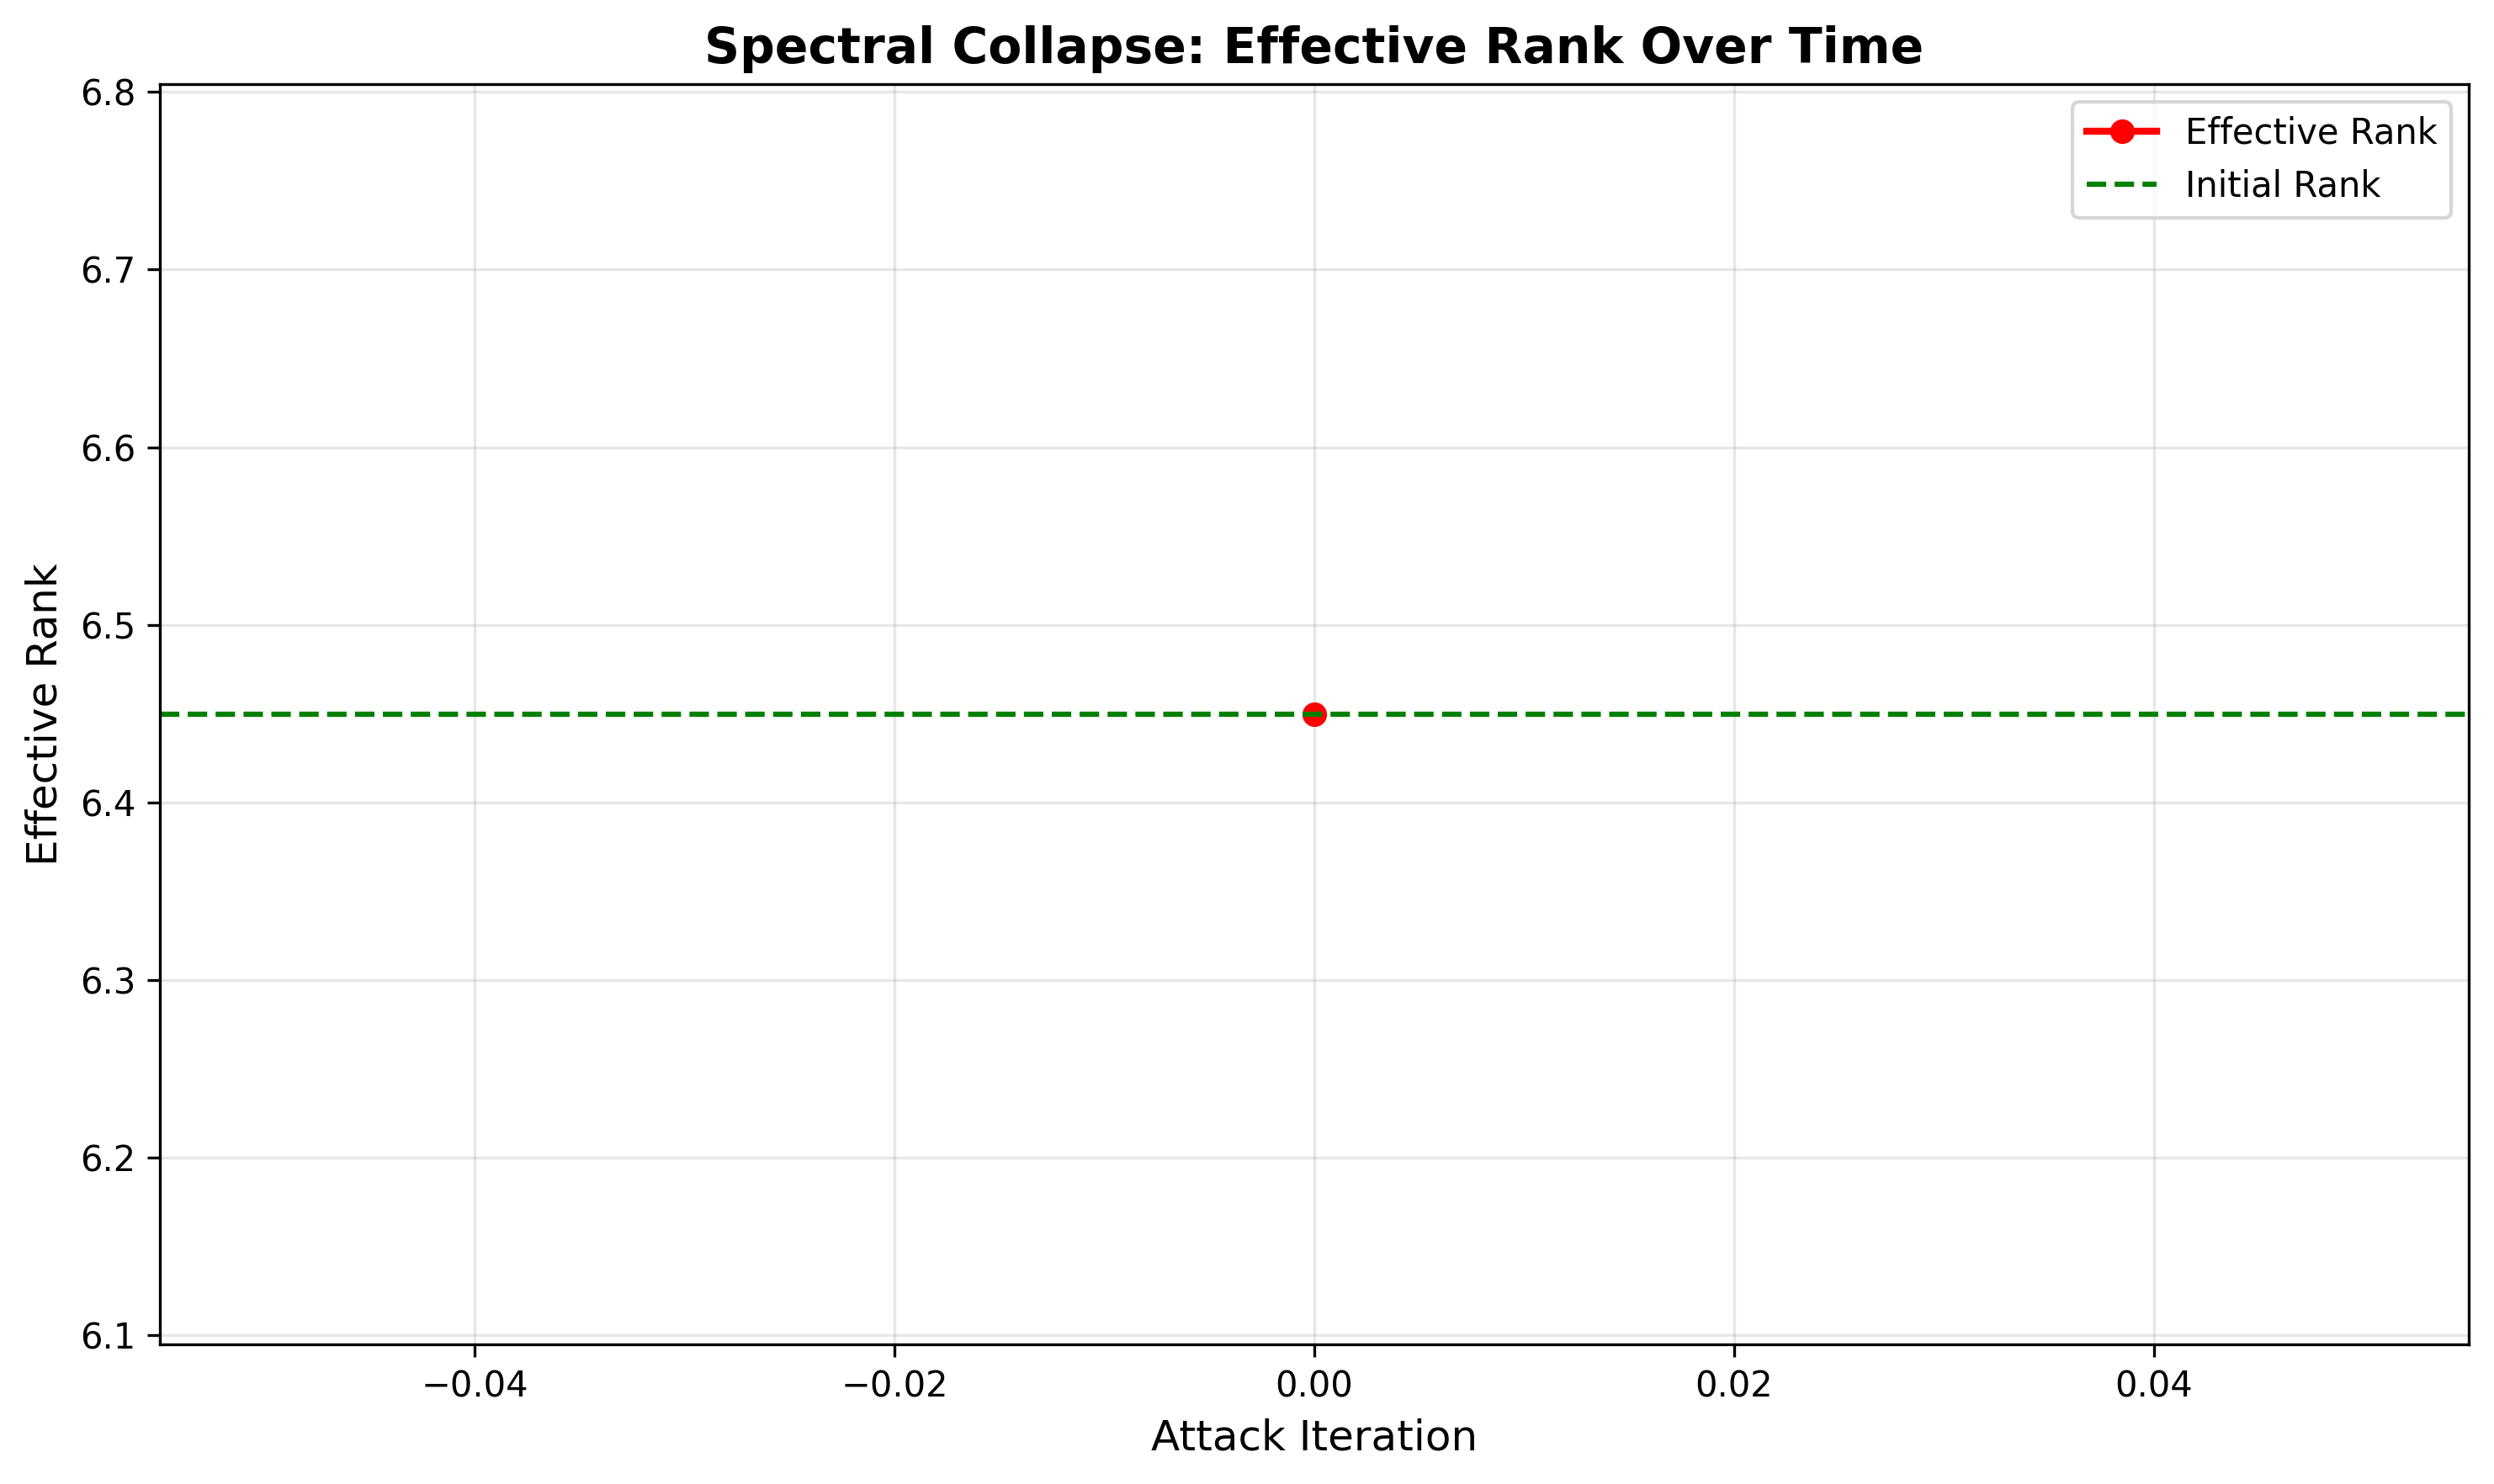


🎯 Model degradation complete!
The model has experienced spectral collapse - rank reduced by -0.1%

💾 Results saved to: /backup/d.yin/NeuroEntropy/experiments/results/demo/pythia_160m_pythia-160m_fp16_eigen_prion

📝 Next Steps:
   • Run full Priority experiments: python experiments/01_pythia_160m/experiment_orchestrator.py --priority 1
   • Analyze results: python experiments/01_pythia_160m/analyze_experiments.py 1 --results-dir /backup/d.yin/NeuroEntropy/experiments/results/demo


In [7]:
# Visualize results
# Check if visualization files exist
rank_collapse_plot = latest_run / "treatment_rank_collapse.png"
rank_reduction_plot = latest_run / "treatment_rank_reduction.png"
spectral_decay_plot = latest_run / "spectral_decay.png"

print("\n📈 Generated Visualizations:")
if rank_collapse_plot.exists():
    print(f"  ✓ Rank collapse plot: {rank_collapse_plot.name}")
if rank_reduction_plot.exists():
    print(f"  ✓ Rank reduction plot: {rank_reduction_plot.name}")
if spectral_decay_plot.exists():
    print(f"  ✓ Spectral decay plot: {spectral_decay_plot.name}")

# Display the rank collapse plot if available
if rank_collapse_plot.exists():
    from IPython.display import Image, display
    print(f"\n{'='*70}")
    print("Rank Collapse Visualization:")
    print(f"{'='*70}")
    display(Image(str(rank_collapse_plot)))
else:
    # Fallback: Create a simple visualization from metrics
    if baseline_data and post_attack_data:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Simple before/after comparison
        ranks = [initial_rank, final_rank]
        labels = ['Baseline', 'Post-Attack']
        colors = ['green', 'red']
        
        ax.bar(labels, ranks, color=colors, alpha=0.7, width=0.5)
        ax.axhline(y=initial_rank, color='g', linestyle='--', alpha=0.5, label='Initial Rank')
        ax.set_ylabel('Effective Rank', fontsize=12)
        ax.set_title(f'Spectral Collapse: Rank Reduction ({rank_reduction_pct:.1f}%)', 
                     fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

print(f"\n{'='*70}")
print("🎯 Model degradation complete!")
print(f"The model has experienced spectral collapse - rank reduced by {rank_reduction_pct:.1f}%")
print(f"{'='*70}")

# Show where results are saved
print(f"\n💾 Results saved to: {latest_run}")
print(f"\n📝 Next Steps:")
print(f"   • Run full Priority experiments: python experiments/01_pythia_160m/experiment_orchestrator.py --priority 1")
print(f"   • Analyze results: python experiments/01_pythia_160m/analyze_experiments.py 1 --results-dir {output_dir}")

## Running Full Priority Experiments

For complete experimental suites (Priority 1-4), use the `experiment_orchestrator.py`:

**Priority 1: Scaling Law** (all models)
```bash
python experiments/01_pythia_160m/experiment_orchestrator.py --priority 1 --num-runs 10
```

**Priority 2: Placebo Test** (treatment specificity)
```bash
python experiments/01_pythia_160m/experiment_orchestrator.py --priority 2 --num-runs 3
```

**Priority 3: Mechanism Test** (optimizer comparison)
```bash
python experiments/01_pythia_160m/experiment_orchestrator.py --priority 3 --num-runs 3
```

**Priority 4: Shield Matrix** (quantization defense)
```bash
python experiments/01_pythia_160m/experiment_orchestrator.py --priority 4 --model 1b --num-runs 3
```

The orchestrator automatically:
- Sets up correct output directories (`priority<N>_<name>/raw_data/`)
- Configures models, precisions, and optimizers
- Handles FFT/QLoRA mode selection
- Manages random seeds across runs

See `experiments/01_pythia_160m/README.md` for full documentation.